<div style="max-width:66ch;">

# Lecture notes - Data augmentation

This is the lecture note for **data augmentation**. 

<p class = "alert alert-info" role="alert"><b>Note</b> that this lecture note gives a brief introduction to data augmentation. I encourage you to read further about data augmentation. </p>

Read more:

- [ImageDataGenerator - TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator?version=nightly)
- [Data augmentation - wikipedia](https://en.wikipedia.org/wiki/Data_augmentation)
- [Data augmentation cheat sheet - S. Amidi](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks)

</div>


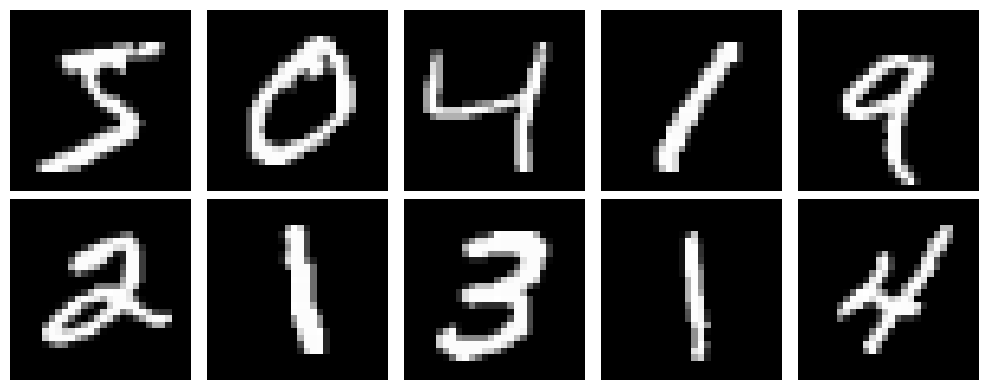

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets.mnist import load_data
import numpy as np

(X_train, y_train), (X_test, y_test) = load_data()
y_train, y_test = y_train.ravel(), y_test.ravel()

def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")
    fig.tight_layout()

plot_samples(X_train)


In [2]:

X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
print(f"{X_train.min()=}, {X_train.max()=}")

X_train.min()=0.0, X_train.max()=1.0


## Train|val|test split

In [3]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=1 / 6, random_state=42
)

In [4]:
# ImageDataGenerator requires rank 4 
X_train_val = X_train_val[:,:,:,None]
X_val = X_val[:,:,:,None]
X_train = X_train[:,:,:,None]
X_test = X_test[:,:,:,None]

X_train_val.shape

(50000, 28, 28, 1)

<div style="max-width:66ch;">

## Data augmentation

Deep learning models require lots of data to be trained on and a cheap way to get a lot of data is to augment existing one. This can be done through flipping, rotating, scaling, addin noise, randomly cropping, zooming in randomly, adding colors, removing information, change contrast etc. 

- ImageDataGenerator to augment images

</div>

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    height_shift_range=0.2,
    width_shift_range=0.2,
)
# don't augment test data and validation data as we want to test on original data
# we just instantiate an ImageDataGenerator without augmentation
test_image_generator = ImageDataGenerator()

# batch size 32 for mini-batch gradient descent 
train_val_generator = train_image_generator.flow( # NumpyArrayIterator
    X_train_val, y_train_val, batch_size=32
)# batch size 32 for mini-batch gradient descent

# batch size 32 for mini-batch gradient descent 
train_generator = train_image_generator.flow(
    X_train, y_train, batch_size=32
)

val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

# NumpyArrayIterator
train_val_generator, val_generator

(<keras.src.legacy.preprocessing.image.NumpyArrayIterator at 0x246818bb450>,
 <keras.src.legacy.preprocessing.image.NumpyArrayIterator at 0x246fdd2cd90>)

In [9]:
# Get the next batch and store it in a variable
next_batch = next(train_val_generator)

# Now you can use next_batch for multiple operations without advancing the iterator
num_samples = len(next_batch)
print(num_samples)

image_shape = next_batch[0].shape
print(image_shape)


2
(32, 28, 28, 1)


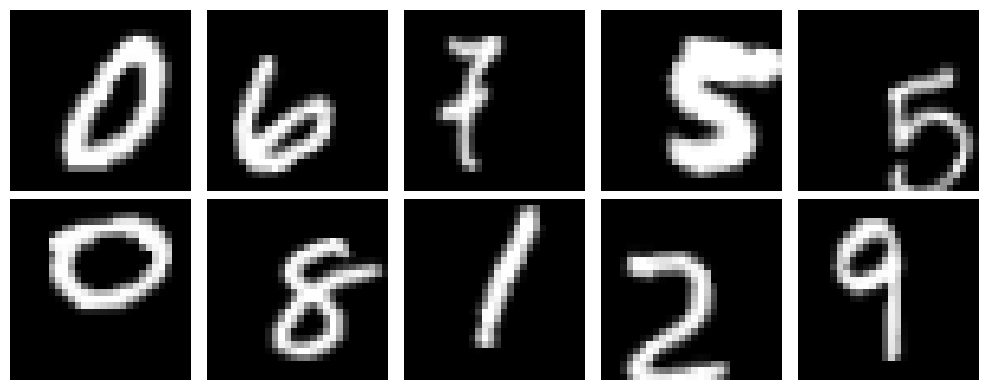

In [10]:
plot_samples(next_batch[0])

<div style="max-width:66ch;">

## CNN model

</div>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate=0.001, drop_rate=0.5, kernels=[32, 32]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel,
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=X_train.shape[1:],
        )

        model.add(conv_layer)
        # defaults to pool_size if None
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["acc"]
    )

    return model

model = CNN_model(drop_rate=.5)

model.summary()



Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dropout (Dropout)           (None, 800)               0 

<div style="max-width:66ch;">

## Train on augmented data

 - steps_per_epoch is the number of times we generate our data from the generator
 - since we have batches on 32 samples for each time we generate, we could count how many samples before we cover original data size
 - 50000/32 = 

</div>

In [ ]:
steps_per_epochs = len(X_train_val)/32
validation_steps = len(X_val)/32

steps_per_epochs, validation_steps


(1562.5, 312.5)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True
)

model.fit(
    train_val_generator,
    steps_per_epoch=1500,
    epochs=100,
    callbacks=[early_stopper],
    validation_data=val_generator,
    validation_steps=312,
)


Epoch 1/100
1500/1500 [==============================] - 27s 16ms/step - loss: 0.6205 - acc: 0.7968 - val_loss: 0.1054 - val_acc: 0.9699
Epoch 2/100
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2590 - acc: 0.9181 - val_loss: 0.0877 - val_acc: 0.9739
Epoch 3/100
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2013 - acc: 0.9362 - val_loss: 0.0639 - val_acc: 0.9810
Epoch 4/100
1500/1500 [==============================] - 23s 15ms/step - loss: 0.1776 - acc: 0.9451 - val_loss: 0.0635 - val_acc: 0.9811
Epoch 5/100
1500/1500 [==============================] - 23s 16ms/step - loss: 0.1606 - acc: 0.9495 - val_loss: 0.0546 - val_acc: 0.9821
Epoch 6/100
1500/1500 [==============================] - 23s 15ms/step - loss: 0.1504 - acc: 0.9527 - val_loss: 0.0455 - val_acc: 0.9857
Epoch 7/100
1500/1500 [==============================] - 23s 15ms/step - loss: 0.1373 - acc: 0.9572 - val_loss: 0.0457 - val_acc: 0.9852
Epoch 8/100
1500/1500 [==================

In [ ]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,loss,acc,val_loss,val_acc
0,0.620524,0.796766,0.105393,0.969852
1,0.258994,0.918119,0.087706,0.973858
2,0.201345,0.936187,0.063899,0.980970
3,0.177557,0.945086,0.063530,0.981070
4,0.160638,0.949462,0.054601,0.982071


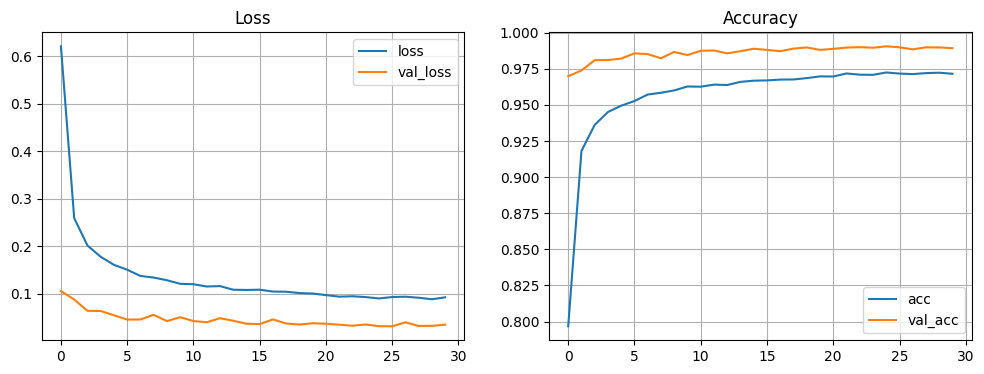

In [ ]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], title = "Loss", grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], title = "Accuracy", grid = True)

plot_metrics(metrics)
# val accuracy is higher than train accuracy, probably due to train data being
# augmented, which gives a lot of varieties in data and is harder to overfit

## Train on all training data

In [ ]:
model = CNN_model()
model.fit(
    train_generator,
    steps_per_epoch=1500,
    epochs=30,
)


Epoch 1/30
1500/1500 [==============================] - 23s 15ms/step - loss: 0.6287 - acc: 0.7926
Epoch 2/30
1500/1500 [==============================] - 22s 14ms/step - loss: 0.2682 - acc: 0.9145
Epoch 3/30
1500/1500 [==============================] - 22s 14ms/step - loss: 0.2079 - acc: 0.9342
Epoch 4/30
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1915 - acc: 0.9392
Epoch 5/30
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1611 - acc: 0.9490
Epoch 6/30
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1508 - acc: 0.9527
Epoch 7/30
1500/1500 [==============================] - 22s 14ms/step - loss: 0.1440 - acc: 0.9560
Epoch 8/30
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1315 - acc: 0.9594
Epoch 9/30
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1293 - acc: 0.9590
Epoch 10/30
1500/1500 [==============================] - 21s 14ms/step - loss: 0.1217 - acc: 0.9610
Epoch 11/

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      0.99      0.99      1135
           2       0.98      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



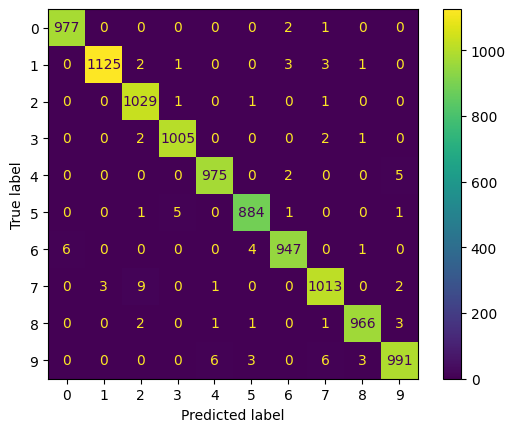

In [ ]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

y_pred = model.predict(X_test)
#y_pred = np.argmax(y_pred)

y_pred = np.argmax(y_pred, axis = 1)


print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

<div style="max-width:66ch;">

## Summary

In this lecture we've covered data augmentation, which is an important and cheap technique to augment our data to get more variations of data to train the deep learning model. To artificially get even more training data we could use simulation methods to get synthetic datasets. Also generative AI models could be used to get synthetic data for training.
    
</div>

<div style="background-color: #FFF; color: #212121; border-radius: 1px; width:22ch; box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px; display: flex; justify-content: center; align-items: center;">
<div style="padding: 1.5em 0; width: 70%;">
    <h2 style="font-size: 1.2rem;">Kokchun Giang</h2>
    <a href="https://www.linkedin.com/in/kokchungiang/" target="_blank" style="display: flex; align-items: center; gap: .4em; color:#0A66C2;">
        <img src="https://content.linkedin.com/content/dam/me/business/en-us/amp/brand-site/v2/bg/LI-Bug.svg.original.svg" width="20"> 
        LinkedIn profile
    </a>
    <a href="https://github.com/kokchun/Portfolio-Kokchun-Giang" target="_blank" style="display: flex; align-items: center; gap: .4em; margin: 1em 0; color:#0A66C2;">
        <img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width="20"> 
        Github portfolio
    </a>
    <span>AIgineer AB</span>
<div>
</div>
